# 🌤️ Multi-City Weather Prediction System

**Objective**: Modify a basic temperature prediction notebook so that it can predict temperature as the main target, with weather conditions as an optional feature, for the cities of Saint-Émilion, Paris, and Silicon Valley.

## Data Sources:
- **Historical Data**: Meteostat (Training dataset)
- **Global Weather Features**: ERA5-Land (Copernicus) - Enrich the model
- **Real-Time Data**: Meteostat / OpenWeatherMap - Model input for predictions
- **Comparison Data**: Météo-France / NOAA - Evaluate model performance

## 📥 Import and Setup

In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
Multi-City Weather Prediction System
Predicts temperature for Saint-Émilion, Paris, and Silicon Valley
Using Meteostat, ERA5-Land, and comparing with official forecasts
"""

import os
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datetime import datetime, timedelta
import requests
from meteostat import Point, Daily, Hourly
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

2025-10-08 20:37:25.816718: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-08 20:37:25.860291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-08 20:37:26.802340: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
Pandas version: 2.3.2


## 🌍 City Configuration

In [2]:
@dataclass
class City:
    name: str
    lat: float
    lon: float
    timezone: str
    meteo_france_station: str = None
    noaa_station: str = None

CITIES = {
    'paris': City('Paris', 48.8566, 2.3522, 'Europe/Paris', 'PARIS'),
    'silicon_valley': City('Silicon Valley', 37.3875, -122.0575, 'America/Los_Angeles', None, 'KSJC')
}

# API Keys (replace with your actual keys)
OPENWEATHER_API_KEY = "9831a5fb2b1386a9a8c3eeac4f8200fa"
METEO_FRANCE_API_KEY = None  # Public API, no key needed
COPERNICUS_API_KEY = "YOUR_COPERNICUS_API_KEY"

print("Cities configured:")
for key, city in CITIES.items():
    print(f"- {city.name}: ({city.lat}, {city.lon})")

Cities configured:
- Paris: (48.8566, 2.3522)
- Silicon Valley: (37.3875, -122.0575)


## 🌤️ Data Collection from Meteostat

In [3]:
def collect_historical_data_meteostat(city, start_date, end_date, frequency='daily'):
    """
    Collect historical weather data from Meteostat
    
    Parameters:
    - city: City dataclass object
    - start_date: datetime object
    - end_date: datetime object
    - frequency: 'daily' or 'hourly'
    
    Returns:
    - pandas DataFrame with weather data
    """
    print(f"\n📊 Collecting {frequency} data for {city.name}...")
    
    location = Point(city.lat, city.lon)
    
    try:
        if frequency == 'daily':
            data = Daily(location, start_date, end_date)
            df = data.fetch()
        else:  # hourly
            data = Hourly(location, start_date, end_date)
            df = data.fetch()
        
        if df.empty:
            print(f"⚠️ No data found for {city.name}")
            return None
        
        print(f"✅ Collected {len(df)} records for {city.name}")
        return df
    
    except Exception as e:
        print(f"❌ Error collecting data for {city.name}: {e}")
        return None


def collect_all_cities_historical_data(years_back=10, frequency='daily'):
    """
    Collect historical data for all cities
    
    Returns:
    - Dictionary with city names as keys and DataFrames as values
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=years_back*365)
    
    all_data = {}
    
    for city_key, city in CITIES.items():
        df = collect_historical_data_meteostat(city, start_date, end_date, frequency)
        if df is not None:
            df['city'] = city.name
            df['lat'] = city.lat
            df['lon'] = city.lon
            all_data[city_key] = df
    
    return all_data

In [4]:
# Collect historical data for all cities
print("="*80)
print("📥 STEP 1: Collecting Historical Data")
print("-" * 80)

historical_data = collect_all_cities_historical_data(years_back=10, frequency='daily')
name_col = None
if not historical_data:
    print("❌ No data collected. Please check your internet connection.")
else:
    print(f"\n✅ Successfully collected data for {len(historical_data)} cities")
    
    # Display data overview
    for city_key, df in historical_data.items():
        print(f"\n{CITIES[city_key].name}:")
        print(f"  - Records: {len(df)}")
        print(f"  - Date range: {df.index.min()} to {df.index.max()}")
        print(f"  - Columns: {list(df.columns)}")
        print(f"  - Sample data:")
        print(df.head(3))
        df = df.fillna(0)
        print(df.info())
        name_col = df.columns
print(name_col)
        

📥 STEP 1: Collecting Historical Data
--------------------------------------------------------------------------------

📊 Collecting daily data for Paris...
✅ Collected 3649 records for Paris

📊 Collecting daily data for Silicon Valley...
✅ Collected 3650 records for Silicon Valley

✅ Successfully collected data for 2 cities

Paris:
  - Records: 3649
  - Date range: 2015-10-12 00:00:00 to 2025-10-07 00:00:00
  - Columns: ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'city', 'lat', 'lon']
  - Sample data:
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun  \
time                                                                       
2015-10-12  11.3   8.8  15.0   0.0  <NA>  <NA>   9.9  <NA>  1015.7  <NA>   
2015-10-13   9.6   7.8  11.7   0.0  <NA>  <NA>  14.9  <NA>  1018.4  <NA>   
2015-10-14   7.0   3.8  10.4   2.8  <NA>  <NA>  11.2  <NA>  1019.7  <NA>   

             city      lat     lon  
time                                
2

## 🧹 Data Preprocessing and Feature Engineering

In [5]:
import numpy as np
import pandas as pd

def create_time_features(df):
    """
    Create time-based features from datetime index
    """
    df = df.copy()
    
    # Extract time components
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    # Cyclical encoding for periodic features
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df


def preprocess_data(data_dict):
    """
    Clean, merge, and standardize datasets for neural network training.
    
    Target: predict temp_avg, temp_min, and temp_max.
    """
    print("\n🧹 Preprocessing data...")

    all_dfs = {}

    for city_key, df in data_dict.items():
        if df is None or df.empty:
            continue
        
        df = df.copy()

        # --- 1️⃣ Standardize column names
        column_mapping = {
            'tavg': 'temp_avg',
            'tmin': 'temp_min',
            'tmax': 'temp_max',
            'prcp': 'precipitation',
            'snow': 'snowfall',
            'wdir': 'wind_direction',
            'wspd': 'wind_speed',
            'wpgt': 'wind_gust',
            'pres': 'pressure',
            'tsun': 'sunshine'
        }
        df = df.rename(columns=column_mapping)

        # --- 3️⃣ Fill missing numeric values with 0
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(0)

        # --- 4️⃣ Add temporal features
        df = create_time_features(df)

        # --- 5️⃣ Keep only rows with valid temperature data
        if not {'temp_avg', 'temp_min', 'temp_max'}.issubset(df.columns):
            print(f"⚠️ Missing temperature columns in {city_key}, skipping.")
            continue

        df = df[(df['temp_avg'] != 0) | (df['temp_min'] != 0) | (df['temp_max'] != 0)]

        all_dfs[city_key] = df
    # --- 8️ Return cleaned data
    return all_dfs


🧹 STEP 2: Preprocessing Data
--------------------------------------------------------------------------------

🧹 Preprocessing data...

Data overview after preprocessing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3649 entries, 2015-10-12 to 2025-10-07
Freq: D
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp_avg         3649 non-null   Float64
 1   temp_min         3649 non-null   Float64
 2   temp_max         3649 non-null   Float64
 3   precipitation    3649 non-null   Float64
 4   snowfall         3649 non-null   Float64
 5   wind_direction   3649 non-null   Float64
 6   wind_speed       3649 non-null   Float64
 7   wind_gust        3649 non-null   Float64
 8   pressure         3649 non-null   Float64
 9   sunshine         3649 non-null   Float64
 10  city             3649 non-null   object 
 11  lat              3649 non-null   float64
 12  lon              3649 non-null   float64
 13  d

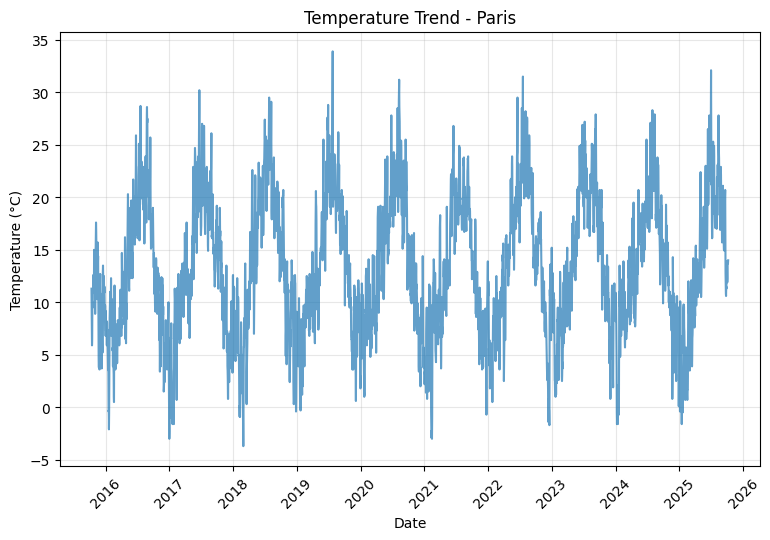


Statistical summary by city:

Paris:
count       3649.0
mean     13.341409
std       6.546619
min           -3.7
25%            8.5
50%           12.8
75%           18.6
max           33.9
Name: temp_avg, dtype: Float64

Data overview after preprocessing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 2015-10-12 to 2025-10-08
Freq: D
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temp_avg         3650 non-null   Float64
 1   temp_min         3650 non-null   Float64
 2   temp_max         3650 non-null   Float64
 3   precipitation    3650 non-null   Float64
 4   snowfall         3650 non-null   Float64
 5   wind_direction   3650 non-null   Float64
 6   wind_speed       3650 non-null   Float64
 7   wind_gust        3650 non-null   Float64
 8   pressure         3650 non-null   Float64
 9   sunshine         3650 non-null   Float64
 10  city             3650 non-null   object 
 11  lat    

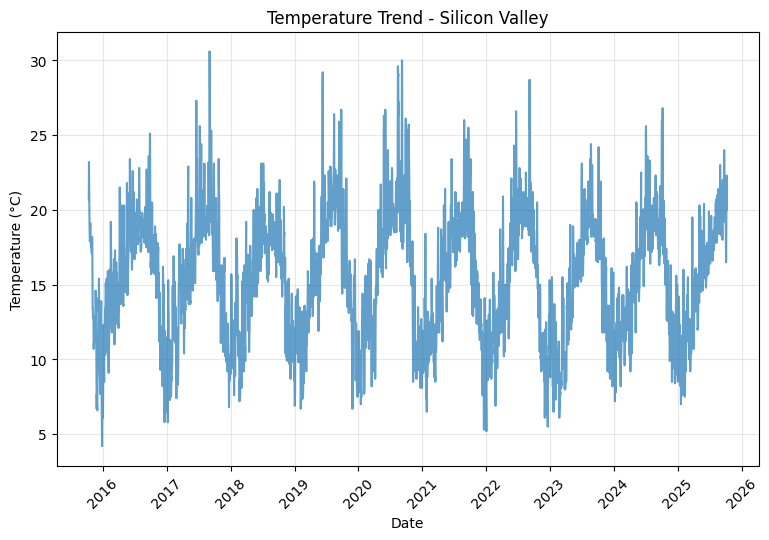


Statistical summary by city:

Silicon Valley:
count       3650.0
mean     15.404384
std       4.202075
min            4.2
25%           12.0
50%           15.6
75%           18.6
max           30.6
Name: temp_avg, dtype: Float64


In [6]:
# Preprocess data
print("="*80)
print("🧹 STEP 2: Preprocessing Data")
print("-" * 80)



combined_df = preprocess_data(historical_data)

for cities, df in combined_df.items():

    print("\nData overview after preprocessing:")
    print(df.info())
    print("\nSample of processed data:")
    print(df.head())

    # Visualize temperature trends
    plt.figure(figsize=(15, 10))

    for i, city_key in enumerate(CITIES.keys()):
        city_data = df[df['city'] == CITIES[city_key].name]
        if not city_data.empty:
            plt.subplot(2, 2, i+1)
            plt.plot(city_data.index, city_data['temp_avg'], alpha=0.7, label=f'{CITIES[city_key].name}')
            plt.title(f'Temperature Trend - {CITIES[city_key].name}')
            plt.xlabel('Date')
            plt.ylabel('Temperature (°C)')
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistical summary
    print("\nStatistical summary by city:")
    for city_key in CITIES.keys():
        city_data = df[df['city'] == CITIES[city_key].name]
        if not city_data.empty:
            print(f"\n{CITIES[city_key].name}:")
            print(city_data['temp_avg'].describe())

## 📊 Data Preparation for Model

In [7]:
@dataclass
class ModelConfig:
    WINDOW_SIZE: int = 30  # 30 days lookback
    BATCH_SIZE: int = 32
    SHUFFLE_BUFFER_SIZE: int = 1000
    FORECAST_HORIZON: int = 7  # Predict 7 days ahead
    SPLIT_RATIO: float = 0.8

def prepare_sequences(df, config):
    """
    Prepare input (X) and output (y) sequences for neural network training.

    - Standardize numeric inputs using StandardScaler (mean=0, std=1)
    - Normalize temperature outputs using MinMaxScaler (range [0, 1])
    - Keep all columns starting with 'temp_' as both inputs and outputs
    """

    print("\n⚙️ Preparing sequences with sklearn scalers...")

    # --- 1️⃣ Identify columns
    temp_cols = [c for c in df.columns if c.startswith('temp_')]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # --- 2️⃣ Define inputs and outputs
    X = df[numeric_cols].values.astype(np.float32)
    y = df[temp_cols].values.astype(np.float32)

    # --- 3️⃣ Standardize inputs
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X)

    # --- 4️⃣ Normalize targets
    y_scaler = MinMaxScaler()
    y_scaled = y_scaler.fit_transform(y)

    # --- 5️⃣ Split train/validation
    split_idx = int(len(X_scaled) * config.SPLIT_RATIO)
    X_train, X_val = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_val = y_scaled[:split_idx], y_scaled[split_idx:]

    print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
    print(f"✅ Validation: X={X_val.shape}, y={y_val.shape}")
    print(f"📊 Features used: {numeric_cols}")
    print(f"🎯 Targets normalized: {temp_cols}")

    # --- 6️⃣ Return data and fitted scalers
    scalers = {
        "X_scaler": X_scaler,
        "y_scaler": y_scaler,
        "feature_cols": numeric_cols,
        "target_cols": temp_cols
    }

    return (X_train, y_train, X_val, y_val), scalers



def create_windowed_dataset(X, y, window_size, forecast_horizon, batch_size, shuffle=True):
    """
    Create a windowed TensorFlow dataset for multi-horizon forecasting.
    
    Args:
        X: np.array, features
        y: np.array, targets
        window_size: int, length of input sequence
        forecast_horizon: int, number of steps to predict
        batch_size: int
        shuffle: bool, whether to shuffle dataset
    
    Returns:
        tf.data.Dataset
    """
    X_windows, y_windows = [], []
    
    for i in range(len(X) - window_size - forecast_horizon + 1):
        X_windows.append(X[i:i+window_size])
        y_windows.append(y[i+window_size:i+window_size+forecast_horizon])
    
    if len(X_windows) == 0:
        raise ValueError("Dataset too small for the given window_size and forecast_horizon.")
    
    X_windows = np.array(X_windows, dtype=np.float32)
    y_windows = np.array(y_windows, dtype=np.float32)
    
    dataset = tf.data.Dataset.from_tensor_slices((X_windows, y_windows))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(1000, len(X_windows)))
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [8]:
# Prepare sequences
print("="*80)
print("📊 STEP 3: Preparing Sequences")
print("-" * 80)

config = ModelConfig()

# Dictionnaires pour stocker les données par ville
train_data = {}
val_data = {}
datasets = {}

for city, df in combined_df.items():
    # Préparer les séquences
    (X_train, y_train, X_val, y_val), scalers = prepare_sequences(df, config)
    
    # Stocker dans les dictionnaires
    train_data[city] = (X_train, y_train)
    val_data[city] = (X_val, y_val)
    
    # Créer les datasets windowed
    train_dataset = create_windowed_dataset(
        X_train, y_train, 
        config.WINDOW_SIZE, 
        config.FORECAST_HORIZON, 
        config.BATCH_SIZE, 
        shuffle=True
    )
    val_dataset = create_windowed_dataset(
        X_val, y_val, 
        config.WINDOW_SIZE, 
        config.FORECAST_HORIZON, 
        config.BATCH_SIZE, 
        shuffle=False
    )
    
    datasets[city] = {
        "train": train_dataset,
        "val": val_dataset,
        "scalers": scalers
    }

    print(f"\n🏙 City: {city}")
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation data shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Features: {scalers['feature_cols']}")
    print(f"Targets: {scalers['target_cols']}")
    print(f"Training batches: {len(list(train_dataset))}")
    print(f"Validation batches: {len(list(val_dataset))}")

print("\n✅ All datasets created successfully")


📊 STEP 3: Preparing Sequences
--------------------------------------------------------------------------------

⚙️ Preparing sequences with sklearn scalers...
✅ Training: X=(2919, 20), y=(2919, 3)
✅ Validation: X=(730, 20), y=(730, 3)
📊 Features used: ['temp_avg', 'temp_min', 'temp_max', 'precipitation', 'snowfall', 'wind_direction', 'wind_speed', 'wind_gust', 'pressure', 'sunshine', 'lat', 'lon', 'day_of_year', 'month', 'day_of_month', 'day_of_week', 'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos']
🎯 Targets normalized: ['temp_avg', 'temp_min', 'temp_max']

🏙 City: paris
Training data shape: X=(2919, 20), y=(2919, 3)
Validation data shape: X=(730, 20), y=(730, 3)
Features: ['temp_avg', 'temp_min', 'temp_max', 'precipitation', 'snowfall', 'wind_direction', 'wind_speed', 'wind_gust', 'pressure', 'sunshine', 'lat', 'lon', 'day_of_year', 'month', 'day_of_month', 'day_of_week', 'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos']
Targets: ['temp_avg', 'temp_min', 

2025-10-08 20:37:28.122866: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-08 20:37:28.165513: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-08 20:37:28.170832: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-08 20:37:28.215198: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 🧠 Model Architecture

In [9]:
def create_temperature_model(window_size, n_features, forecast_horizon=7, dropout_rate=0.2, n_targets=3):
    """
    Create a Conv1D + LSTM model for multi-horizon temperature prediction.
    
    Args:
        window_size: int, input sequence length
        n_features: int, number of input features
        forecast_horizon: int, number of steps to predict
        dropout_rate: float, dropout probability

    Returns:
        Compiled tf.keras.Model
    """
    model = tf.keras.Sequential([
        # Conv1D for local pattern extraction
        tf.keras.layers.Conv1D(64, 3, activation="relu", padding='causal', input_shape=[window_size, n_features]),

        # LSTM layers for sequential learning
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.LSTM(32, return_sequences=False),
        
        # Dense layers for final prediction
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(forecast_horizon * n_targets),
        tf.keras.layers.Reshape((forecast_horizon, n_targets)) 
    ])
    
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mae", "mse"]
    )
    
    return model

In [10]:
# --- Create and compile model for a specific city
example_city = list(datasets.keys())[0]
X_example, _ = train_data[example_city]
n_features = X_example.shape

print("="*80)
print("🧠 STEP 4: Creating Model Architecture")
print("-" * 80)

model = create_temperature_model(
    config.WINDOW_SIZE, 
    n_features[1], 
    config.FORECAST_HORIZON
)

print("Model architecture:")
model.summary()

# Plot model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='templates/assets/température/model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True
)
print("\n✅ Model architecture saved as 'templates/assets/température/models/model_architecture.png'")


🧠 STEP 4: Creating Model Architecture
--------------------------------------------------------------------------------
Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           693 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,253 (340.83 KB)

 Trainable params: 87,253 (340.83 KB)

 Non-trainable params: 0 (0.00 B)


✅ Model architecture saved as 'templates/assets/température/models/model_architecture.png'


## 📈 Training and Prediction

In [11]:
def train_model(model, train_dataset, val_dataset, epochs=50):
    """
    Train the model with early stopping.
    
    Args:
        model: tf.keras.Model, compiled model
        train_dataset: tf.data.Dataset for training
        val_dataset: tf.data.Dataset for validation
        epochs: int, number of training epochs

    Returns:
        history: tf.keras.callbacks.History
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return history


def predict_7day_forecast(model, recent_data, scalers, window_size):
    """
    Predict 7-day temperature forecast using the trained model.
    
    Args:
        model: tf.keras.Model, trained model
        recent_data: np.array, last days of raw features (shape: [window_size, n_features])
        scalers: dict, containing 'X_scaler' and optionally 'y_scaler'
        window_size: int, number of past steps to use for prediction
    
    Returns:
        forecast: np.array, 7-day forecast in original scale (shape: [7, 3])
    """
    # Extract scalers
    X_scaler = scalers['X_scaler']
    y_scaler = scalers.get('y_scaler', None)
    
    # Standardize recent data
    recent_scaled = X_scaler.transform(recent_data[-window_size:])  # shape: (window_size, n_features)
    
    # Reshape for model: (1, window_size, n_features)
    X_input = recent_scaled.reshape(1, window_size, recent_scaled.shape[1])
    
    # Predict
    y_pred_scaled = model.predict(X_input, verbose=0)[0]  # shape: (7, 3)
    
    # Inverse transform if y_scaler is available
    if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Direct transform without reshape
    else:
        y_pred = y_pred_scaled
    
    return y_pred


🧠 STEP 5: Training Models
--------------------------------------------------------------------------------

🏙 Training model for city: paris
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0346 - mae: 0.1911 - mse: 0.0693 - val_loss: 0.0045 - val_mae: 0.0764 - val_mse: 0.0090
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0064 - mae: 0.0898 - mse: 0.0129 - val_loss: 0.0046 - val_mae: 0.0768 - val_mse: 0.0092
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0055 - mae: 0.0835 - mse: 0.0111 - val_loss: 0.0046 - val_mae: 0.0774 - val_mse: 0.0093
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0050 - mae: 0.0793 - mse: 0.0100 - val_loss: 0.0047 - val_mae: 0.0766 - val_mse: 0.0093
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0047 - mae: 0.0767 - mse: 0.0093 - val_loss: 0.0048 - val_mae: 0.0785 - val_mse: 0.0095
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - mae: 0.0744 - mse: 0.0088 - val_loss: 0.0052 -

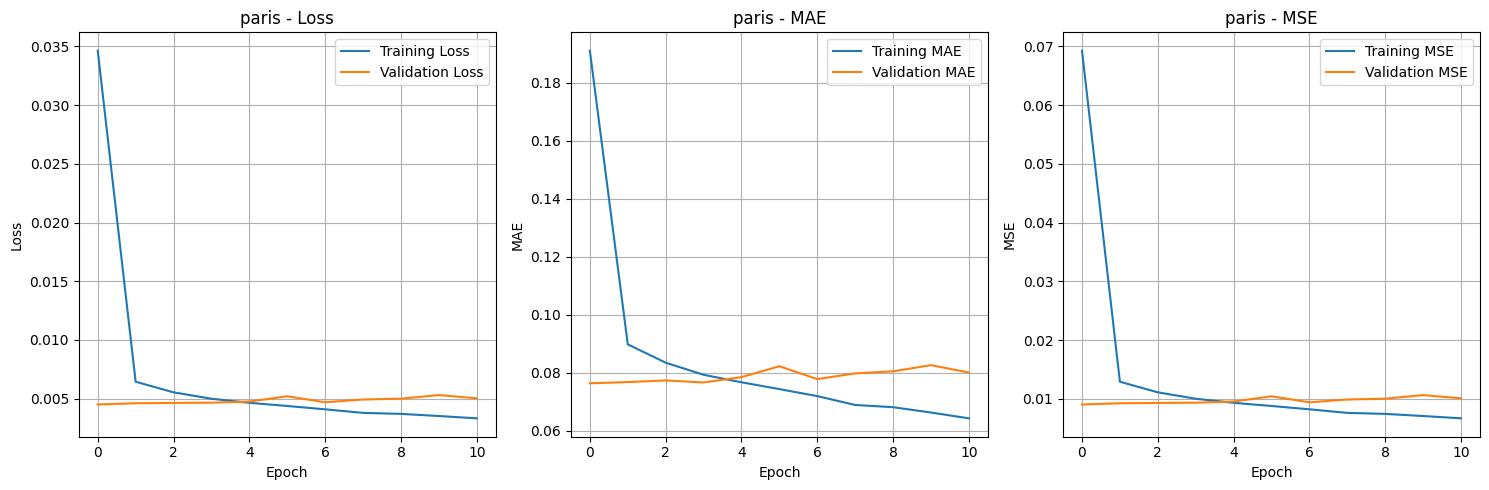


✅ paris training completed!
Final validation loss: 0.0050
Final validation MAE: 0.0801°C

🏙 Training model for city: silicon_valley
Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0236 - mae: 0.1590 - mse: 0.0473 - val_loss: 0.0040 - val_mae: 0.0714 - val_mse: 0.0080
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0065 - mae: 0.0897 - mse: 0.0130 - val_loss: 0.0038 - val_mae: 0.0672 - val_mse: 0.0077
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0056 - mae: 0.0824 - mse: 0.0111 - val_loss: 0.0035 - val_mae: 0.0636 - val_mse: 0.0069
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0051 - mae: 0.0791 - mse: 0.0102 - val_loss: 0.0041 - val_mae: 0.0690 - val_mse: 0.0082
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0048 - mae: 0.0760 - mse: 0.0095 - val_loss: 0.0036 - val_mae: 0.0645 - val_mse: 0.0071
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0044 - mae: 0.0733 - mse: 0.0088 - val_loss: 0.0043 - val_mae

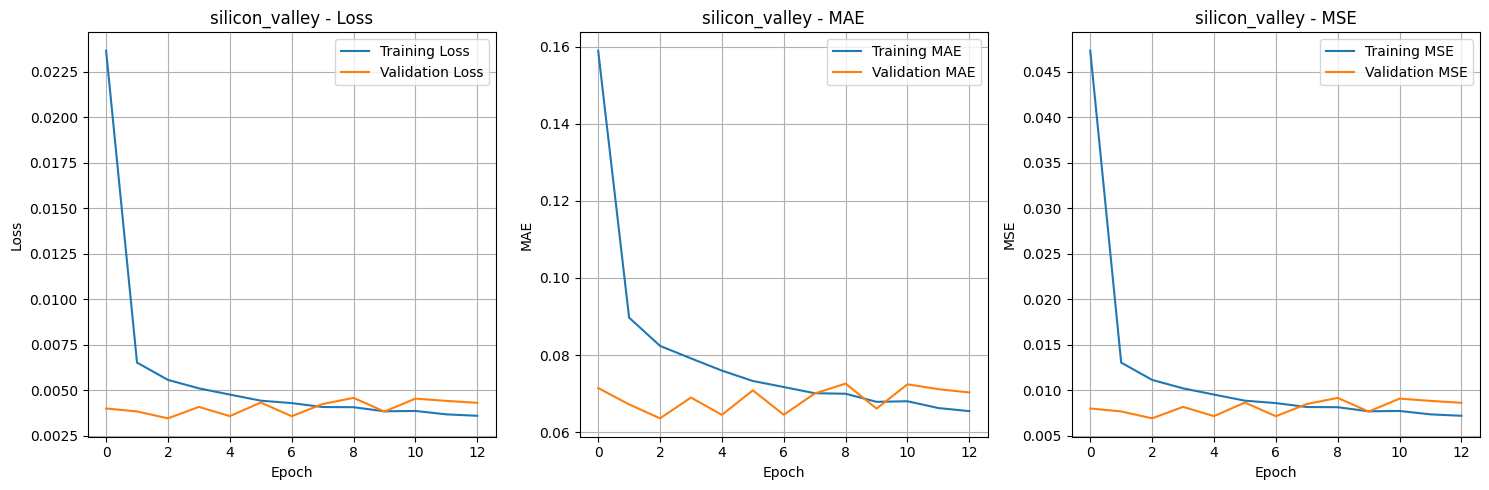


✅ silicon_valley training completed!
Final validation loss: 0.0043
Final validation MAE: 0.0703°C


In [12]:
# --- STEP 5: Training Models per City
print("="*80)
print("🧠 STEP 5: Training Models")
print("-" * 80)

histories = {}
trained_models = {}

for city, data in datasets.items():
    print(f"\n🏙 Training model for city: {city}")
    
    # Extract datasets and scalers
    train_dataset = data['train']
    val_dataset = data['val']
    
    # Create a new model instance
    X_train_example, _ = train_data[city]
    n_features = X_train_example.shape[1]
    
    model = create_temperature_model(
        window_size=config.WINDOW_SIZE,
        n_features=n_features,
        forecast_horizon=config.FORECAST_HORIZON
    )
    
    # Train the model
    history = train_model(model, train_dataset, val_dataset, epochs=50)
    
    # Store model and history
    trained_models[city] = model
    histories[city] = history
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{city} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{city} - MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title(f'{city} - MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\n✅ {city} training completed!")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final validation MAE: {history.history['val_mae'][-1]:.4f}°C")
    model.save(f'templates/assets/température/models/{city}_model.keras')


## ⚖️ Comparison with Official Forecasts

In [13]:
def get_openweather_forecast(city, days=8):
    """Get 8-day forecast from OpenWeatherMap (today + 7 days)"""
    url = "http://api.openweathermap.org/data/2.5/forecast"
    params = {
        'lat': city.lat,
        'lon': city.lon,
        'appid': OPENWEATHER_API_KEY,
        'units': 'metric'
    }
    
    response = requests.get(url, params=params, timeout=10)
    data = response.json()
    
    # Group by day
    daily_data = {}
    for item in data['list']:
        date = datetime.fromtimestamp(item['dt']).date()
        if date not in daily_data:
            daily_data[date] = {'temps': [], 'temp_min': [], 'temp_max': []}
        daily_data[date]['temps'].append(item['main']['temp'])
        daily_data[date]['temp_min'].append(item['main']['temp_min'])
        daily_data[date]['temp_max'].append(item['main']['temp_max'])
    
    # Calculate daily averages
    forecast = []
    for date in sorted(daily_data.keys())[:days]:
        forecast.append({
            'date': date,
            'temp_avg': np.mean(daily_data[date]['temps']),
            'temp_min': np.min(daily_data[date]['temp_min']),
            'temp_max': np.max(daily_data[date]['temp_max'])
        })
    
    return forecast

## 📊 Visualization and Evaluation

In [14]:
for city_key, city in CITIES.items():
    trained_models[city_key] = tf.keras.models.load_model(f'templates/assets/température/models/{city_key}_model.keras')



In [15]:

print("\n" + "="*80)
print("🔮 PREDICTIONS AND COMPARISON")
print("="*80)

for city_key, city in CITIES.items():
    print(f"\n📍 {city.name}")
    print("-" * 60)
    
    # Get recent data and make prediction
    df = combined_df[city_key]
    recent_data = df[datasets[city_key]['scalers']['feature_cols']].tail(config.WINDOW_SIZE).values
    
    model = trained_models[city_key]
    scalers = datasets[city_key]['scalers']
    
    # Predict with model (today + 7 days)
    model_pred = predict_7day_forecast(model, recent_data, scalers, config.WINDOW_SIZE)
    
    # Get OpenWeatherMap forecast
    ow_forecast = get_openweather_forecast(city)
    
    # Compare
    today = datetime.now().date()
    print(f"\n{'Date':<12} {'Model Avg':<12} {'Model Min':<12} {'Model Max':<12} {'OW Avg':<12} {'OW Min':<12} {'OW Max':<12} {'Δ Avg':<10}")
    print("-" * 110)
    
    mae_list = []
    for i in range(min(len(model_pred), len(ow_forecast))):
        date = today + timedelta(days=i)
        m_avg, m_min, m_max = model_pred[i]
        ow = ow_forecast[i]
        
        diff_avg = m_avg - ow['temp_avg']
        mae_list.append(abs(diff_avg))
        
        print(f"{date} {m_avg:>10.1f}°C {m_min:>10.1f}°C {m_max:>10.1f}°C "
              f"{ow['temp_avg']:>10.1f}°C {ow['temp_min']:>10.1f}°C {ow['temp_max']:>10.1f}°C "
              f"{diff_avg:>8.1f}°C")
    
    print(f"\n📊 MAE: {np.mean(mae_list):.2f}°C")

print("\n✅ Comparison complete!")


🔮 PREDICTIONS AND COMPARISON

📍 Paris
------------------------------------------------------------

Date         Model Avg    Model Min    Model Max    OW Avg       OW Min       OW Max       Δ Avg     
--------------------------------------------------------------------------------------------------------------
2025-10-08       13.9°C       10.4°C       18.9°C       13.7°C       12.7°C       13.7°C      0.2°C
2025-10-09       12.3°C       10.3°C       17.7°C       15.5°C       10.2°C       20.5°C     -3.2°C
2025-10-10       11.5°C        9.3°C       17.6°C       16.2°C       12.5°C       20.5°C     -4.6°C
2025-10-11       13.1°C        9.2°C       18.6°C       16.9°C       13.0°C       21.6°C     -3.8°C
2025-10-12       13.0°C        9.5°C       18.0°C       16.4°C       12.7°C       21.1°C     -3.4°C
2025-10-13       13.4°C        9.3°C       17.4°C       15.2°C       11.4°C       19.8°C     -1.8°C

📊 MAE: 2.84°C

📍 Silicon Valley
-----------------------------------------------------

In [16]:
for city, data in datasets.items():
    scalers = data['scalers']
    
    model_info = {
        'feature_cols': scalers['feature_cols'],
        'target_cols': scalers['target_cols'],
        'n_features': len(scalers['feature_cols']),
        'n_targets': len(scalers['target_cols']),
        'window_size': config.WINDOW_SIZE,
        'forecast_horizon': config.FORECAST_HORIZON,
        'training_date': datetime.now().isoformat(),
        'name_col': name_col
    }
    
    # Sauvegarder les informations
    info_path = f'templates/assets/température/models/{city}_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"✅ Saved model info for {city} to {info_path}")
    print(f"   Features: {model_info['n_features']}")
    print(f"   Targets: {model_info['n_targets']}")

✅ Saved model info for paris to templates/assets/température/models/paris_info.pkl
   Features: 20
   Targets: 3
✅ Saved model info for silicon_valley to templates/assets/température/models/silicon_valley_info.pkl
   Features: 20
   Targets: 3
